In [25]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase

from analysis.weekly_analysis import WeeklyAnalysis as anas

## risk and return class imports
from returns.products import Products as returns_products_class
from strategy.strategy import Strategy as strategy_list
from fund.fund import Fund
## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [26]:
strats = [
          strategy_list.STOCK_WEEKLY_SPECULATION,
          strategy_list.CRYPTO_WEEKLY_SPECULATION,
          strategy_list.CRYPTO_WEEKLY_ROLLING,
          strategy_list.STOCK_WEEKLY_ROLLING,
          strategy_list.CRYPTO_WEEKLY_WINDOW,
          strategy_list.STOCK_WEEKLY_WINDOW
         ]
model_start_date  = datetime(2020,1,1)
model_end_date  = datetime(2021,1,1)
current_start_date  = datetime(2021,1,1)
fund = Fund(strats,model_start_date,model_end_date,current_start_date)
fund.initialize_strats()

In [27]:
market = Market()

In [28]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [29]:
tyields = returns_products_class.tyields()
bench_returns = returns_products_class.spy_bench()

In [30]:
t = fund.pull_trades()

In [31]:
t = pd.concat(t)

In [32]:
nonindex_columns = [
"year"
,"week"
,"ticker"
,"delta_sign"
,"delta"
,"returns"
,"floored_returns"
,"position"
,"actual_returns"
,"positions"] 

In [33]:
indexers = []
indexer = []
for col in t.columns:
    if col not in nonindex_columns:
        indexers.append(list(t[col].unique()))
        indexer.append(col)

In [34]:
stuff = t[indexer].to_dict("records")
parameters = [dict(t) for t in {tuple(d.items()) for d in stuff}]

In [35]:
analysis = []
for parameter in parameters:
    try:
        ledger = t.sort_values(["year","week"]).copy()
        for key in parameter.keys():
            ledger = ledger[ledger[key]==parameter[key]]
        positions = int(ledger["positions"].mean())
        if ledger.index.size > 0:
            cumulative = anas.trade_analysis(indexer,ledger,positions,parameter,tyields,bench_returns)
            analysis.append(cumulative[indexer + ["pv","beta","rrr","sharpe"]].iloc[-1])
    except Exception as e:
        print(str(e))
        continue
a = pd.DataFrame(analysis)

In [36]:
a

,value,ceiling,floor,strat,pv,beta,rrr,sharpe
53,False,True,True,weekly_crypto_rolling,0.794845,3.127647,NaN,-0.082348
53,True,True,True,weekly_crypto_rolling,0.794845,3.127647,NaN,-0.082348
53,True,True,False,weekly_crypto_rolling,0.314483,0.612200,NaN,-1.205353
87,False,False,False,weekly_prices_window,0.706367,-3.004242,-0.216181,0.115182
87,True,False,False,weekly_prices_window,0.776946,-2.034546,0.193286,0.135389
87,False,False,True,weekly_prices_window,0.833369,-2.012273,0.202691,0.108847
87,True,False,True,weekly_prices_window,0.874637,-1.459051,0.436296,0.121835
87,False,True,False,weekly_prices_window,0.706367,-3.004242,-0.216181,0.115182
53,False,False,False,weekly_crypto_window,0.161827,0.710913,NaN,-1.252717
53,True,False,False,weekly_crypto_window,0.161827,0.710913,NaN,-1.252717


In [37]:
a.sort_values("pv",ascending=False).groupby("strat").first().reset_index().sort_values("pv")

,strat,value,ceiling,floor,pv,beta,rrr,sharpe
1,weekly_crypto_speculation,False,True,True,0.377926,2.683495,NaN,-0.251342
2,weekly_crypto_window,False,True,True,0.470160,3.194654,NaN,-0.182254
0,weekly_crypto_rolling,True,True,True,0.794845,3.127647,NaN,-0.082348
5,weekly_prices_window,True,False,True,0.874637,-1.459051,0.436296,0.121835
3,weekly_prices_rolling,True,True,True,1.001171,-1.163945,0.560909,0.044013
4,weekly_prices_speculation,False,True,True,1.236032,-0.365604,0.898019,-0.502270


In [38]:
top = a.sort_values("pv",ascending=False).iloc[0]
analysis = t
for key in parameter.keys():
    analysis = analysis[(analysis[key]==top[key])]
ledger = analysis[["year","week","ticker","delta","delta_sign","actual_returns","position"]]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

In [39]:
ledger.sort_values("actual_returns",ascending=False).head(30)

,year,week,ticker,delta,delta_sign,actual_returns,position,GICS Sector,Security
1553,2020.0,13.0,AWK,-0.288155,1.0,1.161809,7,Utilities,American Water Works
652,2020.0,13.0,AWK,-0.288155,1.0,1.161809,7,Utilities,American Water Works
195,2020.0,11.0,AAP,-0.010072,-1.0,1.159098,2,Consumer Discretionary,Advance Auto Parts
1096,2020.0,11.0,AAP,-0.010072,-1.0,1.159098,2,Consumer Discretionary,Advance Auto Parts
1284,2020.0,13.0,AEP,-0.188184,1.0,1.157529,4,Utilities,American Electric Power
383,2020.0,13.0,AEP,-0.188184,1.0,1.157529,4,Utilities,American Electric Power
1494,2020.0,46.0,APD,-0.008138,-1.0,1.148724,6,Materials,Air Products and Chemicals
593,2020.0,46.0,APD,-0.008138,-1.0,1.148724,6,Materials,Air Products and Chemicals
1465,2020.0,13.0,AMT,-0.253690,1.0,1.148263,6,Real Estate,American Tower
564,2020.0,13.0,AMT,-0.253690,1.0,1.148263,6,Real Estate,American Tower


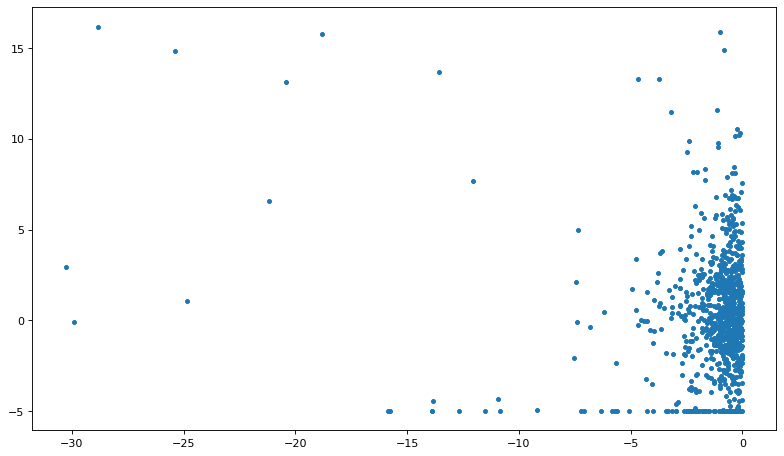

In [40]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger["delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [41]:
portfolio = ledger.pivot_table(index=["year","week"],columns="position",values="actual_returns").fillna(1).reset_index()

In [42]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

In [43]:
cumulative

,0,date_string,date,pv,adjclose,bench
0,1.018000,2020-W2,2020-01-10,0.509000,325.71,1.000000
1,1.018511,2020-W3,2020-01-17,0.509256,331.95,1.019158
2,0.994143,2020-W5,2020-01-31,0.497072,321.73,0.987781
3,0.993347,2020-W6,2020-02-07,0.496674,332.20,1.019926
4,0.958891,2020-W7,2020-02-14,0.479446,337.60,1.036505
...,...,...,...,...,...,...
89,1.234821,2021-W48,2021-12-03,0.617411,453.42,1.392097
90,1.197524,2021-W49,2021-12-10,0.598762,470.74,1.445273
91,1.213480,2021-W50,2021-12-17,0.606740,459.87,1.411900
92,1.254275,2021-W51,2021-12-24,0.627137,474.96,1.458230


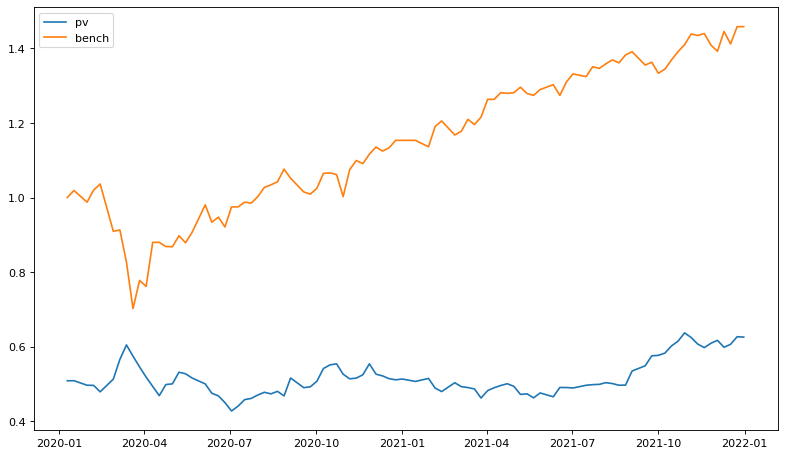

In [44]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

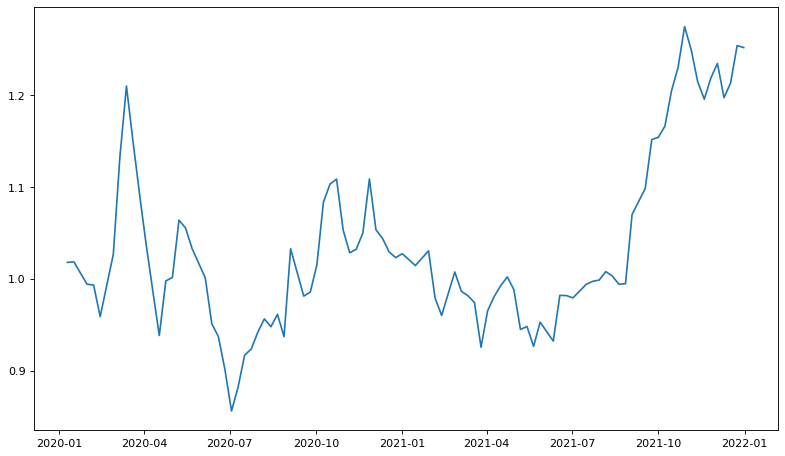

In [45]:
plt.figure(figsize=(12, 7), dpi=80)
position_columns = [x for x in cumulative.columns if x not in ["date_string","date","pv","adjclose","bench"]]
for i in position_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)
plt.show()


In [46]:
ledger.groupby(["GICS Sector"]).mean().sort_values("delta",ascending=False)

,year,week,delta,delta_sign,actual_returns,position
GICS Sector,,,,,,
Financials,2020.529032,26.374194,-0.008214,-0.148387,0.998873,4.406452
Industrials,2020.521277,27.170213,-0.011576,0.042553,1.000027,4.468085
Materials,2020.346939,31.734694,-0.012988,0.102041,0.999382,4.183673
Consumer Staples,2020.461538,31.051282,-0.015099,0.076923,1.008440,4.692308
Information Technology,2020.445783,28.548193,-0.015280,0.072289,1.004169,4.331325
Utilities,2020.530973,28.539823,-0.015661,-0.026549,1.003551,4.610619
Consumer Discretionary,2020.404255,28.617021,-0.015933,-0.148936,1.008548,4.297872
Real Estate,2020.609756,25.756098,-0.016472,0.073171,0.999528,4.634146
Communication Services,2020.480769,25.865385,-0.016697,0.076923,1.006712,4.807692


In [47]:
ledger.groupby(["ticker","Security"]).prod().sort_values("actual_returns",ascending=False).head(20)

,,year,week,delta,delta_sign,actual_returns,position
ticker,Security,,,,,,
AAP,Advance Auto Parts,2.433579e+112,1.177974e+46,4.868015e-80,1.0,2.320765,0.000000e+00
ABMD,Abiomed,4.043814e+125,4.068011e+52,2.580072e-78,1.0,2.224082,0.000000e+00
ADI,Analog Devices,1.455863e+99,4.690244e+41,2.544304e-65,1.0,2.077622,0.000000e+00
AMAT,Applied Materials,8.718169e+85,4.705386e+34,8.210107e-56,1.0,1.782081,0.000000e+00
ATVI,Activision Blizzard,1.273020e+185,2.736857e+74,1.653188e-113,1.0,1.421893,0.000000e+00
MO,Altria,6.746156e+138,6.948177e+56,3.022743e-96,1.0,1.385799,0.000000e+00
ABT,Abbott,2.747257e+145,2.501998e+65,6.939926e-102,1.0,1.339638,0.000000e+00
ABBV,AbbVie,4.605895e+158,6.479602e+66,5.440581e-101,1.0,1.337314,0.000000e+00
ADM,ADM,9.910337e+118,2.934065e+50,4.950794e-73,1.0,1.328530,5.527743e+23


In [48]:
industry_analysis = ledger.pivot_table(index=["year","week"],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,week,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,2.020000e+03,2.000000e+00,1.000000,1.000000,1.013113,1.000000,1.009320,0.986224,1.000000,1.026292,1.000000,1.000000,0.993062
1,4.080400e+06,6.000000e+00,1.019817,1.000000,1.013113,1.000000,1.009134,0.962350,1.013405,1.026807,0.973635,1.000000,0.993062
2,8.242408e+09,3.000000e+01,1.019817,1.000000,1.013113,1.000000,0.989683,0.962350,0.998716,0.994627,1.000457,0.984943,0.986650
3,1.664966e+13,1.800000e+02,1.027908,1.000000,1.013113,1.000000,1.044590,0.914232,0.998716,0.994627,1.000457,0.984943,0.985843
4,3.363232e+16,1.260000e+03,1.027908,1.000000,0.991220,1.000000,1.044590,0.918051,1.005557,0.972965,0.950434,0.966122,0.985843
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,3.094931e+297,4.536808e+120,1.442502,1.301491,1.394107,0.992979,0.932496,1.962812,0.803325,1.500277,1.041149,0.956796,1.087093
90,6.254855e+300,2.223036e+122,1.442502,1.301491,1.375306,0.992979,0.932496,1.912093,0.789879,1.500277,1.041149,0.956796,1.087093
91,1.264106e+304,1.111518e+124,1.420630,1.301491,1.366399,0.992979,0.944441,1.912093,0.793612,1.500277,1.036023,0.956796,1.082893
92,2.554758e+307,5.668742e+125,1.420630,1.301491,1.366399,0.992979,0.967444,1.923907,0.793612,1.425263,1.044266,0.956796,1.083252
